# Time Series Extraction + Random Forest

Dataset dibagi tiap n data kemudian dilakukan ekstraksi fitur berdasarkan domain 'temporal' dengan TSFEL. Digunakan Random Forest untuk classification

In [1]:
import glob, os
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from library.random_forest import RandomForest
from library.utility import temporal, confussion, roc_auc
import matplotlib.pyplot as plt

## Data Preparation

In [2]:
def data_prep(path, n):
    data2 = pd.DataFrame()
    laben = LabelEncoder()
    label = []
    loop = []
    name2 = []
    lab_id = []
    id = []

    for i in ['no', 'yes']    : #folder n stiction, stiction
        files = glob.glob(r'{}\{}\*.csv'.format(path, i)) #list csv di folder
        for j in files :
            name = os.path.basename(j)[:-4]
            data = pd.read_csv(j).loc[:,['PV', 'OP', 'SP']]
            p = int(len(data)/n)
            data = data[:p*n]

            for k in range(len(data)) :
                label.append(i)
                loop.append(name)

            for l in range(0, len(data), n):
                for m in range(n) :
                    id.append(name + f' {int(l/n)}')
                    lab_id.append(i)

            data2 = pd.concat([data2, data]).reset_index(drop=True)
            name2.append(name)
    data2['Error'] = data2.SP - data2.PV
    data2['Loop'] = loop
    loop_id = laben.fit_transform(id)
    data2['ID'] = loop_id
    data2['Label'] = label
    return data2

## Data Features Extraction

In [3]:
def data_extract(data, n, ts, prog):

    extract = temporal(n = n, ts = ts, progress=prog)

    X = extract.extract(data.loc[:,['PV', 'OP']])

    y = pd.DataFrame()
    for i in data.ID.unique() :
        df = data[data.ID == i]
        label = df.Label.mode()
        y = pd.concat([y, label], ignore_index=True)
    
    return X, y

## Dataset Jelali-Huang

In [4]:
path = 'Data\Data Latih ISDB'
n = 100 #ukuran jendela
data = data_prep(path, n)
data

,PV,OP,SP,Error,Loop,ID,Label
0,58.093750,26.750000,58.0,-0.093750,BAS1 mod,0,no
1,57.968750,26.468750,58.0,0.031250,BAS1 mod,0,no
2,57.968750,26.468750,58.0,0.031250,BAS1 mod,0,no
3,58.093750,26.296875,58.0,-0.093750,BAS1 mod,0,no
4,58.093750,26.468750,58.0,-0.093750,BAS1 mod,0,no
...,...,...,...,...,...,...,...
302895,-0.253238,76.289062,0.0,0.253238,POW4,2941,yes
302896,-0.217318,76.367188,0.0,0.217318,POW4,2941,yes
302897,-0.181399,76.445312,0.0,0.181399,POW4,2941,yes
302898,-0.145479,76.523438,0.0,0.145479,POW4,2941,yes


In [5]:
X, y = data_extract(data, n, ts=None, prog=True)


PV Timeseries Feature Extraction


100%|██████████| 3029/3029 [00:06<00:00, 482.16it/s]



OP Timeseries Feature Extraction


100%|██████████| 3029/3029 [00:05<00:00, 604.52it/s]


## Seleksi Fitur

In [6]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
to_drop

['PV Auto Correlation',
 'PV Median Absolute Differences',
 'PV Peak to Peak Distance',
 'PV Positive Turning Point',
 'PV Signal Distance',
 'PV Sum of Absolute Differences',
 'OP Auto Correlation',
 'OP Median Absolute Differences',
 'OP Positive Turning Point',
 'OP Signal Distance',
 'OP Sum of Absolute Differences']

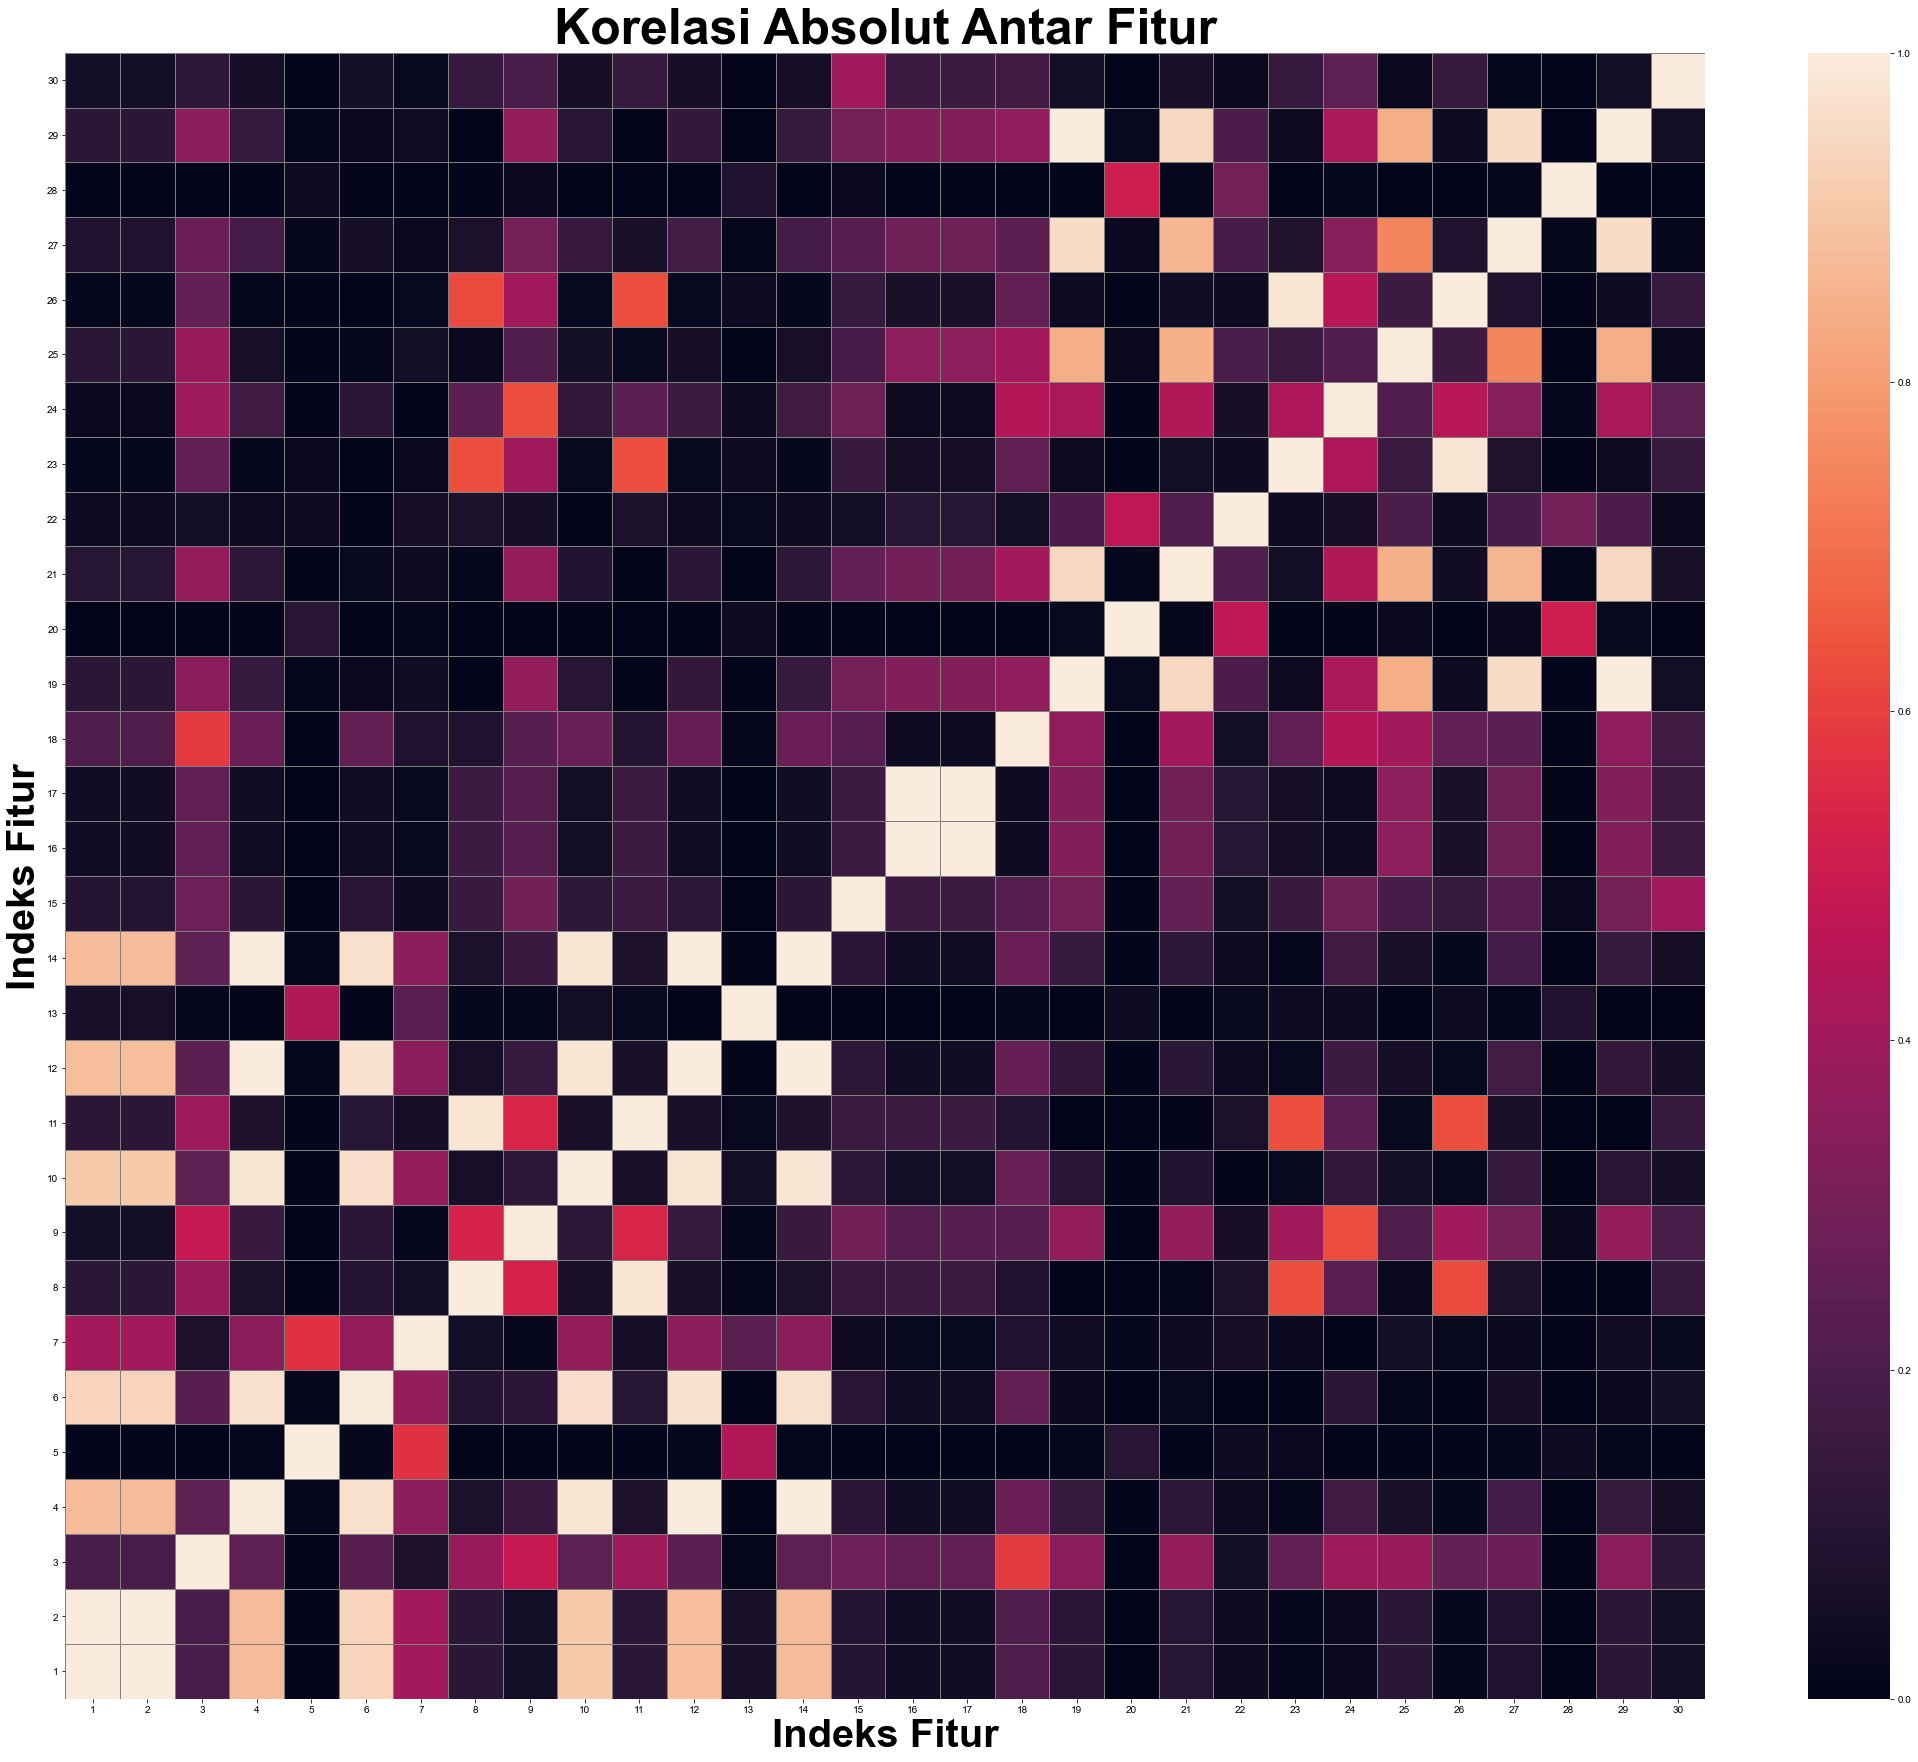

In [7]:
X_b = X.copy()
X_b.columns = [x for x in range(1, len(X.columns)+1)]
X_b.corr().abs().to_csv('hasil\correlation matrix.csv')
fig, ax = plt.subplots(figsize=(30, 25))
sb.heatmap(X_b.corr().abs(), linewidths=1, linecolor='grey', vmin = 0, vmax = 1)
sb.set(font_scale=2)
ax.invert_yaxis()
plt.title('Korelasi Absolut Antar Fitur', fontweight='bold', fontsize = 50)
plt.yticks(rotation=360)
plt.ylabel('Indeks Fitur', fontweight='bold', fontsize = 40)
plt.xlabel('Indeks Fitur', fontweight='bold', fontsize = 40)
plt.tight_layout()
plt.savefig(f'hasil\correlation matrix before.jpg')
plt.show()

In [8]:
X1 = X.copy()
y1 = y.copy().values.ravel()

X1.drop(to_drop, axis=1, inplace=True)

features = X1.columns.tolist()
X1

,PV Absolute Energy,PV Entropy,PV Mean Absolute Differences,PV Mean Differences,PV Median Differences,PV Negative Turning Point,PV Neighbourhood Peaks,PV Slope,PV Zero Crossing Rate,OP Absolute Energy,OP Entropy,OP Mean Absolute Differences,OP Mean Differences,OP Median Differences,OP Negative Turning Point,OP Neighbourhood Peaks,OP Peak to Peak Distance,OP Slope,OP Zero Crossing Rate
0,336182.839844,0.143432,0.038510,0.000000,0.000000,6.0,2.0,-0.000551,0.0,70136.095947,0.386289,0.074653,-0.000473,0.000000,5.0,1.0,0.484375,-0.001569,0.0
1,335364.425781,0.205742,0.048295,-0.000947,0.000000,11.0,1.0,-0.000868,0.0,68931.270508,0.638234,0.092645,-0.003314,0.000000,14.0,1.0,0.718750,-0.003291,0.0
2,335787.891602,0.153825,0.031250,0.000947,0.000000,7.0,1.0,0.000954,0.0,68485.921875,0.507653,0.061395,0.000789,0.000000,8.0,1.0,0.468750,0.000851,0.0
3,335979.812500,0.121357,0.018624,-0.000947,0.000000,3.0,2.0,-0.000568,0.0,68302.133545,0.429488,0.040404,-0.002525,0.000000,6.0,1.0,0.515625,-0.001629,0.0
4,335628.551758,0.156297,0.035669,0.000947,0.000000,8.0,1.0,0.000591,0.0,67422.091797,0.562177,0.077336,0.000631,0.000000,13.0,1.0,0.562500,0.000143,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3024,9.664942,1.000000,0.046512,-0.000447,0.001562,6.0,1.0,-0.002630,6.0,627148.927355,1.000000,0.254056,0.001521,0.105766,2.0,2.0,6.980476,-0.027305,0.0
3025,9.230935,1.000000,0.041989,-0.000065,0.003189,4.0,1.0,-0.002165,4.0,620352.335354,1.000000,0.264378,-0.008103,0.115761,3.0,2.0,6.971703,-0.024076,0.0
3026,9.126739,1.000000,0.038370,-0.000125,-0.005339,4.0,1.0,-0.001801,4.0,621573.702679,1.000000,0.248136,0.000059,0.057510,2.0,2.0,6.608482,-0.021832,0.0
3027,8.617117,1.000000,0.036575,-0.002086,-0.003497,4.0,1.0,-0.003300,4.0,630591.833609,1.000000,0.198450,-0.009457,0.001137,2.0,2.0,5.664673,-0.026738,0.0


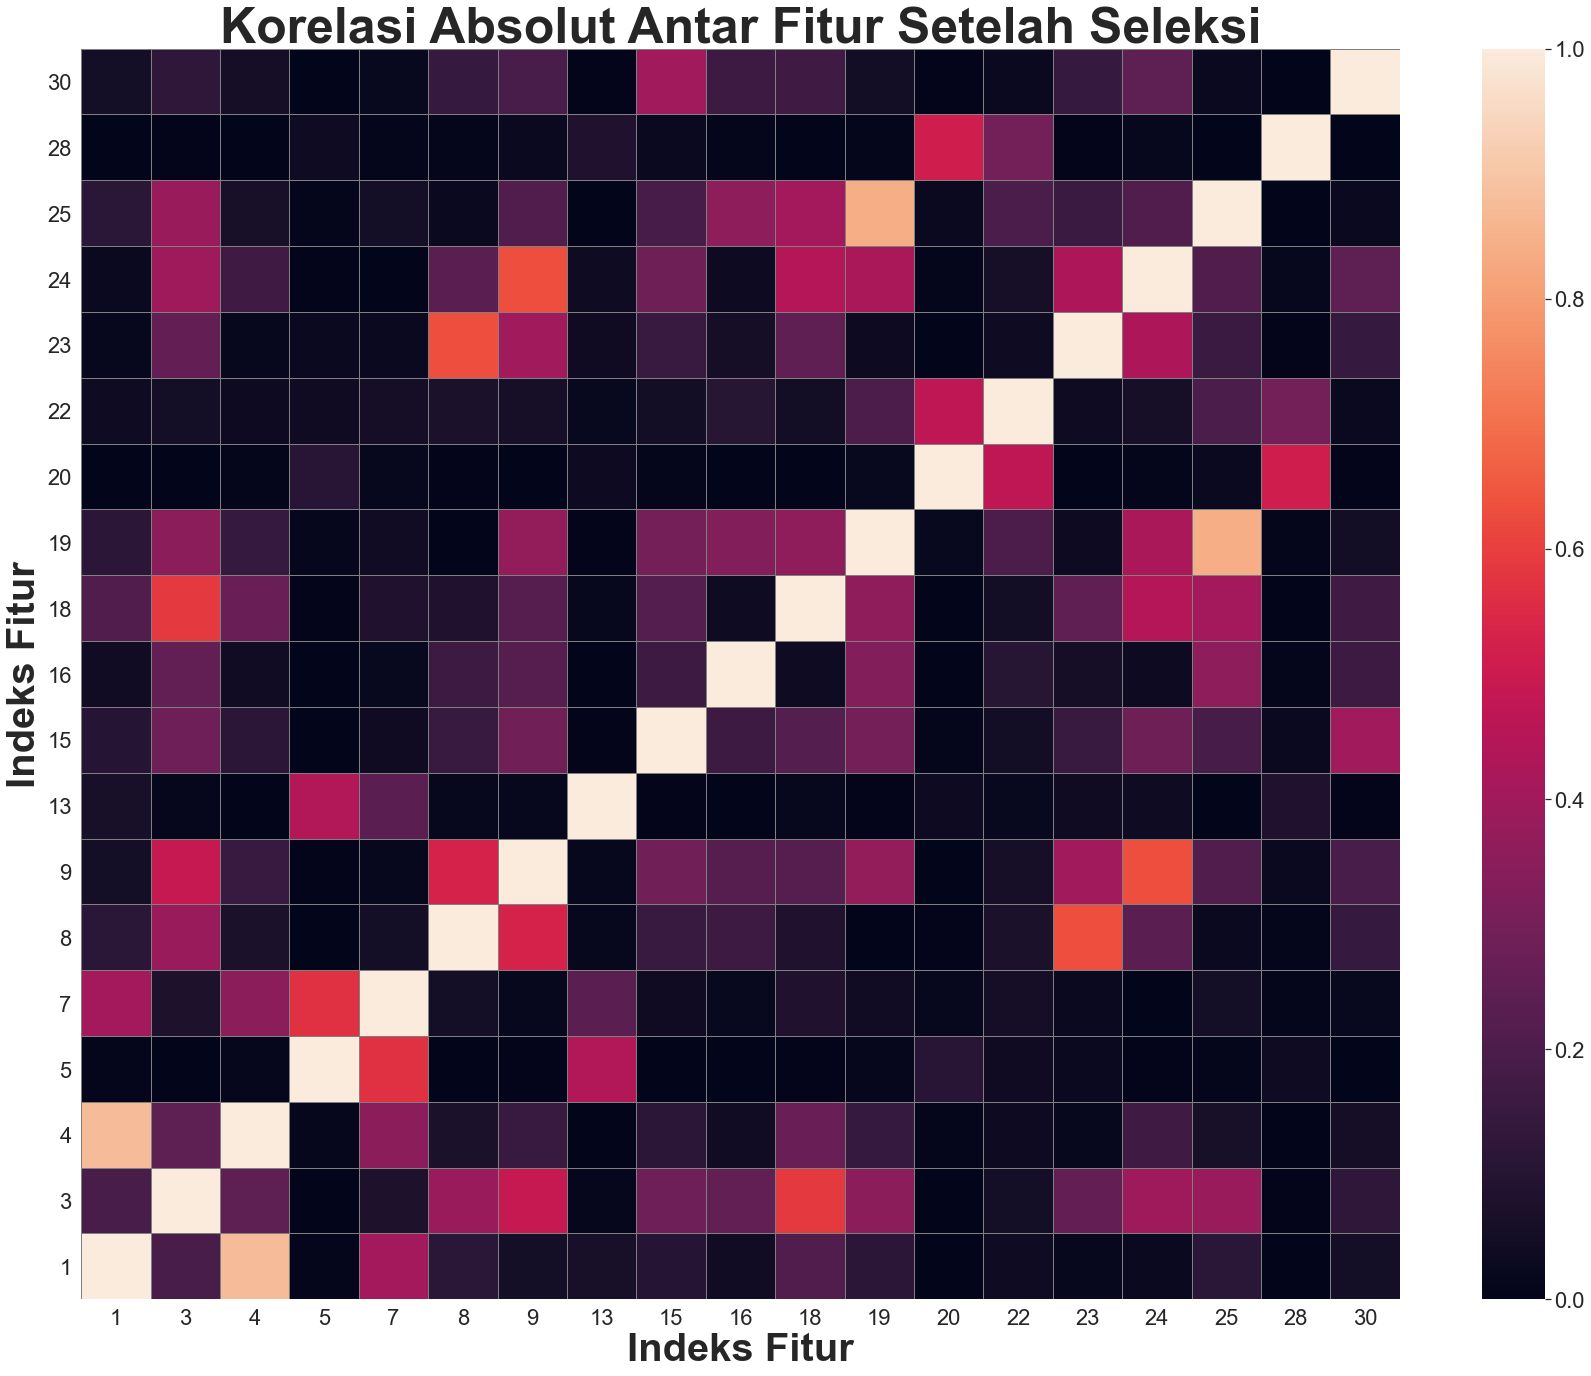

In [9]:
idx2 = []
for j in X1.columns :
    idx = np.where(np.asarray(X.columns) == j)
    idx2.append(idx[0][0])
    
X_b1 = X1.copy()
X_b1.columns = [i+1 for i in idx2]
X_b1.corr().abs().to_csv('hasil\correlation matrix after.csv')
fig, ax = plt.subplots(figsize=(25, 20))
sb.heatmap(X_b1.corr().abs(), linewidths=1, linecolor='grey', vmin=0, vmax = 1)
sb.set(font_scale=3)
ax.invert_yaxis()
plt.title('Korelasi Absolut Antar Fitur Setelah Seleksi', fontweight='bold', fontsize = 50)
plt.yticks(rotation=360)
plt.ylabel('Indeks Fitur', fontweight='bold', fontsize = 40)
plt.xlabel('Indeks Fitur', fontweight='bold', fontsize = 40)
plt.tight_layout()
plt.savefig(f'hasil\correlation matrix after.jpg')
plt.show()

## Dataset Split

In [10]:
encoder = LabelEncoder().fit(y1)
y1 = encoder.transform(y1)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.25, random_state = 42, shuffle = True, stratify = y1)

nX_train = X_train.values
nX_test = X_test.values

## Random Forest Classification Model

In [11]:
min_samples = 20
max_depth = 70
n_trees = 100
max_features = 19

classifier = RandomForest(min_samples=min_samples, max_depth=max_depth, n_trees=n_trees, max_features=max_features) 
classifier.fit(nX_train, y_train)


Random Forest Training


100%|██████████| 100/100 [01:50<00:00,  1.10s/it]



 True Positive    False Positive    True Negative    False Negative
          285                 7              463                 3
                                                                  
  TP Fraction       FP Fraction      TN Fraction       FN Fraction
     0.989583          0.014894         0.985106          0.010417
                                                                  
     Accuracy         Precision           Recall          f1 score
    98.680739          97.60274        98.958333         98.275862 



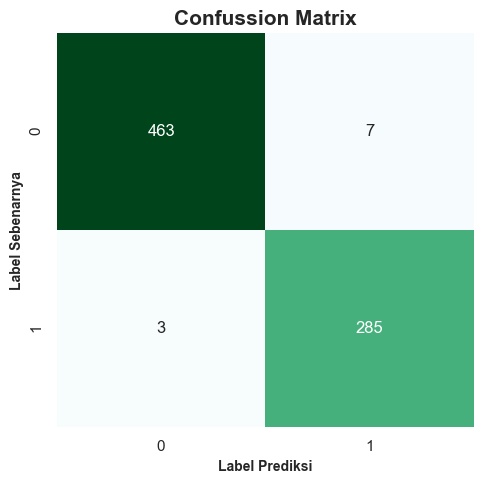

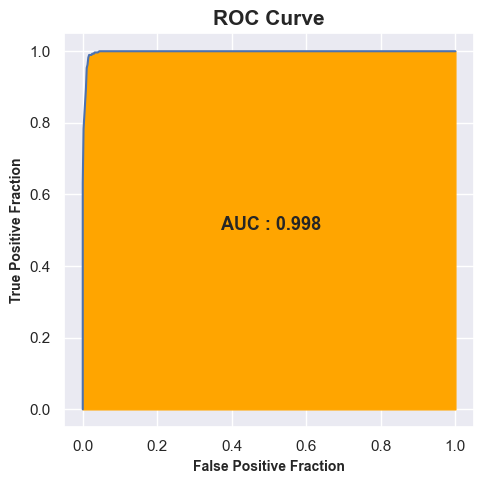

In [12]:
cm = confussion()
roc = roc_auc()
y_pred = classifier.predict(nX_test)
y_pred_prob = classifier.predict_score(nX_test)

sb.set()
FPF_a, TPF_a = cm.matrix(y_real = y_test, y_pred = y_pred, name = 'hasil/Uji ISDB confusion matrix', save=True)
auc = roc.score(y_real=y_test, y_prob=y_pred_prob, save=True, name='hasil/Uji ISDB roc-auc')

## Data Industri

In [13]:
path1 = 'Data\Data Validasi SACAC'
n1 = 100
data1 = data_prep(path1, n1)
data1.head()

,PV,OP,SP,Error,Loop,ID,Label
0,0.34924,0.64931,0.96357,0.61433,other-F-chemicals-thornhill-2003,0,no
1,0.12492,0.66724,0.96357,0.83865,other-F-chemicals-thornhill-2003,0,no
2,0.44282,0.54299,0.96357,0.52075,other-F-chemicals-thornhill-2003,0,no
3,0.59280,0.46357,0.96357,0.37077,other-F-chemicals-thornhill-2003,0,no
4,0.55563,0.42771,0.96357,0.40794,other-F-chemicals-thornhill-2003,0,no


In [14]:
X1n, y1n = data_extract(data=data1, n = n, ts = None, prog = True)
X11 = X1n.copy()[features]
y11 = encoder.transform(y1n.copy().values.ravel())


PV Timeseries Feature Extraction


100%|██████████| 511/511 [00:00<00:00, 571.17it/s]



OP Timeseries Feature Extraction


100%|██████████| 511/511 [00:00<00:00, 594.53it/s]


In [15]:
nX11 = X11.values

y1_real = y11
y1_pred = classifier.predict(nX11)
y1_pred_prob = classifier.predict_score(nX11)

In [16]:
loop = pd.DataFrame()
loop_id = []
for i in data1.ID.unique() :
    df1 = data1[data1.ID == i]
    loop_mode = df1.Loop.mode()
    loop = pd.concat([loop, loop_mode], ignore_index=True)
    loop_id.append(i)

loop_n = pd.DataFrame({'Loop' : loop[0], 'ID' : loop_id, 'Probability Yes' : y1_pred_prob[:, 1],'Probability No' : y1_pred_prob[:, 0], 
                       'Real' : y1_real, 'Prediction' : y1_pred})

loop_n.to_csv('hasil/Hasil Deteksi Offline.csv', index=False)
loop_n

,Loop,ID,Probability Yes,Probability No,Real,Prediction
0,other-F-chemicals-thornhill-2003,0,0.14,0.86,0,0
1,other-F-chemicals-thornhill-2003,1,0.01,0.99,0,0
2,other-F-chemicals-thornhill-2003,12,0.20,0.80,0,0
3,other-F-chemicals-thornhill-2003,23,0.02,0.98,0,0
4,other-F-chemicals-thornhill-2003,34,0.03,0.97,0,0
...,...,...,...,...,...,...
506,stiction-P-oilgas-DB-1-baccidicapaci-2018,405,0.94,0.06,1,1
507,stiction-P-oilgas-DB-1-baccidicapaci-2018,406,0.98,0.02,1,1
508,stiction-P-oilgas-DB-1-baccidicapaci-2018,407,0.98,0.02,1,1
509,stiction-P-oilgas-DB-1-baccidicapaci-2018,408,0.93,0.07,1,1



 True Positive    False Positive    True Negative    False Negative
          218                33              260                 0
                                                                  
  TP Fraction       FP Fraction      TN Fraction       FN Fraction
          1.0          0.112628         0.887372               0.0
                                                                  
     Accuracy         Precision           Recall          f1 score
    93.542074          86.85259            100.0         92.963753 



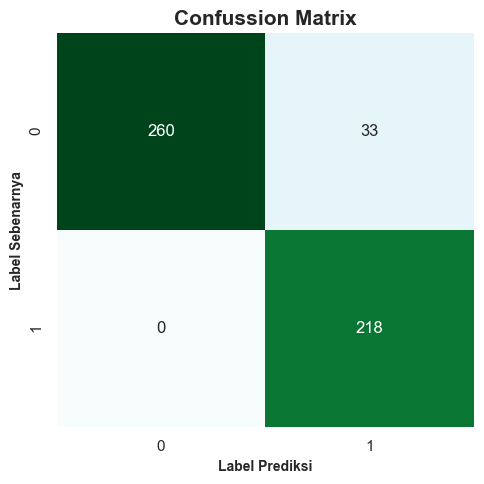

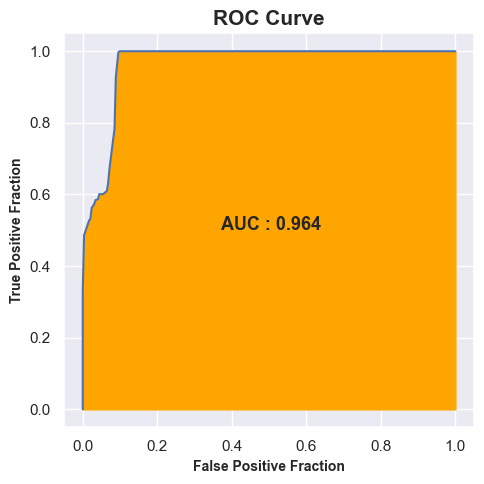

In [17]:
FPF_a, TPF_a = cm.matrix(y_real = loop_n.Real.values, y_pred = loop_n.Prediction.values, name = 'hasil/SACAC confusion matrix', save=True)
auc = roc.score(y_real=loop_n.Real.values, y_prob=y1_pred_prob, save=True, name='hasil/SACAC roc-auc')

## Data Industri Per Loop

In [18]:
loop = pd.DataFrame()
loop_id = []
for i in data1.ID.unique() :
    df1 = data1[data1.ID == i]
    loop_mode = df1.Loop.mode()
    loop = pd.concat([loop, loop_mode], ignore_index=True)
    loop_id.append(i)

loop_real = []
for j in data1.Loop.unique() :
    df2 = data1[data1.Loop == j]
    label2 = df2.Label.mode()[0]
    loop_real.append(label2)

loop_pred = []
loop_pred_prob = []
n_yes = []
n_no = []
for k in loop[0].unique() :
    df3 = loop_n[loop_n.Loop == k]
    label3 = df3.Prediction.mode()[0]
    yes = len(df3[df3.Prediction == 1])
    no = len(df3[df3.Prediction == 0])

    yes_prob = yes/(yes + no)
    no_prob = no/(yes+no)
    loop_pred.append(label3)
    loop_pred_prob.append(np.asarray([no_prob, yes_prob]))
    n_yes.append(yes)
    n_no.append(no)

loop_pred_prob = np.asarray(loop_pred_prob)
loop_real = encoder.transform(loop_real)
per_loop = pd.DataFrame({'Loop' : loop[0].unique(), 'Prediction Yes' : n_yes, 'Prediction No' : n_no, 'Probability Yes' : loop_pred_prob[:, 1],
                         'Probability No' : loop_pred_prob[:, 0], 'Prediction' : loop_pred, 'Real' : loop_real})

percentage = []
for i in range(len(per_loop)):
    if per_loop['Real'].iloc[i] == 0 :       
        percent = per_loop['Prediction Yes'].iloc[i] * 100/ (per_loop['Prediction No'].iloc[i] + per_loop['Prediction Yes'].iloc[i])
    else :
        percent = per_loop['Prediction No'].iloc[i] * 100/ (per_loop['Prediction No'].iloc[i] + per_loop['Prediction Yes'].iloc[i])
    percentage.append(percent)
per_loop['False Percentage'] = percentage
per_loop.to_csv('hasil/Hasil Deteksi Offline (Loop).csv', index=False)
per_loop


,Loop,Prediction Yes,Prediction No,Probability Yes,Probability No,Prediction,Real,False Percentage
0,other-F-chemicals-thornhill-2003,0,86,0.000000,1.000000,0,0,0.000000
1,other-F-paper-horch-2003-2,11,0,1.000000,0.000000,1,0,100.000000
2,other-F-paper-horch-2003,0,11,0.000000,1.000000,0,0,0.000000
3,other-L-paper-horch-2003,1,8,0.111111,0.888889,0,0,11.111111
4,quantisation-F-minerals-bauer-2017,0,10,0.000000,1.000000,0,0,0.000000
5,quantisation-Q-paper-horch-2003,0,11,0.000000,1.000000,0,0,0.000000
6,saturation-L-minerals-bauer-2017,6,26,0.187500,0.812500,0,0,18.750000
7,saturation-T-oilgas-thornhill-2002,0,14,0.000000,1.000000,0,0,0.000000
8,sensor-F-oilgas-thornhill-2007,0,15,0.000000,1.000000,0,0,0.000000
9,tuning-F-chemical-DB-1-baccidicapaci-2018,0,72,0.000000,1.000000,0,0,0.000000



 True Positive    False Positive    True Negative    False Negative
            7                 2               10                 0
                                                                  
  TP Fraction       FP Fraction      TN Fraction       FN Fraction
          1.0          0.166667         0.833333               0.0
                                                                  
     Accuracy         Precision           Recall          f1 score
    89.473684         77.777778            100.0              87.5 



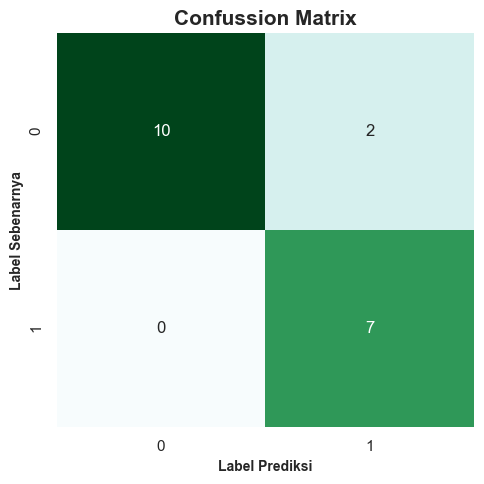

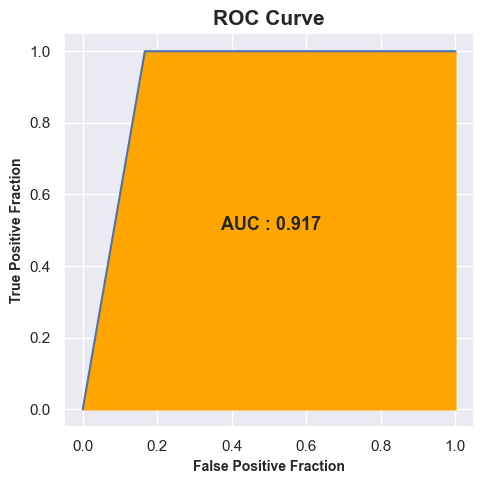

In [19]:
FPF_a, TPF_a = cm.matrix(y_real = per_loop.Real.values, y_pred = per_loop.Prediction.values, name = 'hasil/SACAC loop confusion matrix', save=True)
auc = roc.score(y_real=per_loop.Real.values, y_prob=loop_pred_prob, save=True, name='hasil/SACAC loop roc-auc')